In [201]:
# Import basic
import pandas as pd
import numpy as np
import cv2
# Import plots
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# from keras.models import Sequential
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.models import model_from_json, Model, Sequential, load_model
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM, Dense
from keras.layers.wrappers import TimeDistributed

from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger
from importlib import reload
import visualization
import transformations
import model
import loader
import matplotlib.pyplot as plt
from visualization import plots, hist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

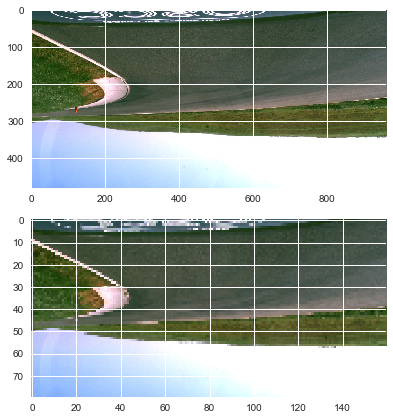

In [340]:
## import config
reload(loader)
reload(config)
reload(transformations)
from loader import *
from config import *
from transformations import *
# path,heading,longitude,latitude,quarternion0,quarternion1,quarternion2,quarternion3,vel0,vel1,vel2,steering,throttle,brake
ROOT = '/Users/nando/Desktop/thunderhill-day1-data'
OUTPUT = '.'

def getDataFromThunderhill(folder, output, normalize=False, randomize=True, balance=False, split=True):
    data = pd.DataFrame(columns=COLUMNS)
    for csvpath in glob.glob('{}/**/output_accel.txt'.format(folder)):
        df = pd.read_csv(csvpath)
        df = df.dropna(axis=0)
        skip = False
        for toSkip in SKIP:
            if toSkip in csvpath:
                skip = True
        if skip:
            continue
        basename = os.path.dirname(csvpath)
        df['center'] = basename + '/' + df['path']
        df['speed'] = np.power(np.power(df['vel0'], 2) + np.power(df['vel0'], 2) + np.power(df['vel0'], 2), 0.5)
        mask = df['accel']>-0.2
        df.loc[mask, 'throttle'] = df[mask]['accel'] + 0.2
        data = data.append(df, ignore_index=True)
    
    if balance:
        # data = data.where(data['steering'] != 0).dropna(axis=0)
        zeros = data.where(data['steering'] == 0).dropna(axis=0).sample(1000)
        non_zeros = data.where(data['steering'] != 0).dropna(axis=0)
        data = zeros.append(non_zeros)

    if randomize:
        data = shuffle(data)

    if normalize:
        scaler = StandardScaler()
        data[COLUMNS_TO_NORMALIZE] = scaler.fit_transform(data[COLUMNS_TO_NORMALIZE])
    if split:
        return train_test_split(data, test_size=0.2, random_state=42)
    return data

def ReadImg(path):
    img = np.array(cv2.cvtColor(cv2.imread(path.strip()), code=cv2.COLOR_BGR2RGB))
    if '320x160' in path:
        img = img[20:140, :, :]
#     if 'thunderhill' in path:
#         img = cv2.resize(img, dsize=(320, 160))
#         img = img[-40:10:-1, :, :]
    return img

df_train = getDataFromThunderhill(ROOT, OUTPUT, randomize=False, balance=False, split=False)
img = ReadImg(df_train['center'][1000])
pimg = Preproc(img)
plots([img, pimg])

In [333]:
df_train['speed'] = np.power(np.power(df_train['vel0'].astype(float), 2) + np.power(df_train['vel1'].astype(float), 2) + np.power(df_train['vel2'].astype(float), 2), 0.5)
df_train[['brake', 'steering', 'speed', 'vel0', 'vel1', 'vel2', 'throttle']].describe()

,brake,steering,speed,vel0,vel1,vel2,throttle
count,35809.000000,35809.000000,35809.000000,35809.000000,35809.000000,35809.000000,35809.000000
mean,0.073887,0.019276,20.163219,-0.410187,-0.639349,-0.007355,0.208114
std,0.154494,0.077934,5.147969,12.891529,16.308571,0.574665,0.086384
min,0.000000,-0.279253,0.000000,-27.710602,-32.523182,-2.071563,0.000000
25%,0.018311,-0.022689,16.433316,-10.461619,-15.102164,-0.396708,0.168297
50%,0.018311,0.003491,20.025008,-1.747157,0.588814,0.120720,0.215327
75%,0.018311,0.068068,23.789745,10.445411,14.549524,0.323044,0.261747
max,1.739502,0.387463,33.706074,28.605457,29.633589,1.644871,0.527708


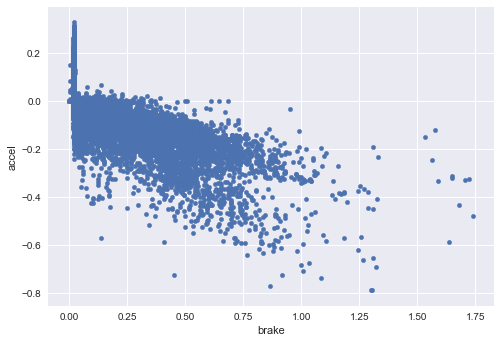

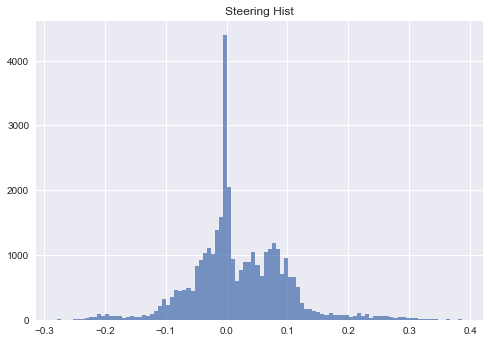

In [334]:
# df_train[df_train['accel'] < 0][['accel', 'brake']]
df_train.plot.scatter(x='brake', y='accel')
plt.show()
hist(df_train, 'steering', title='Steering Hist')

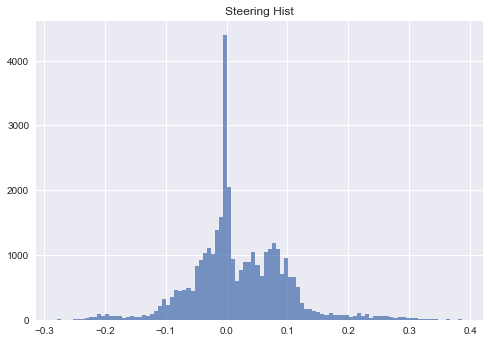

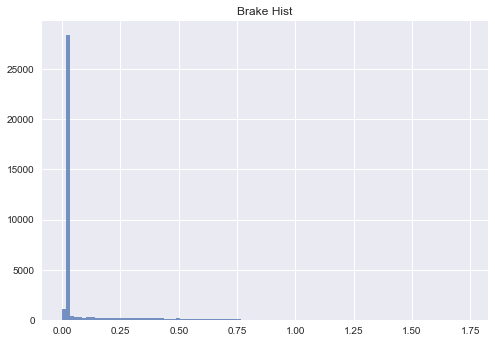

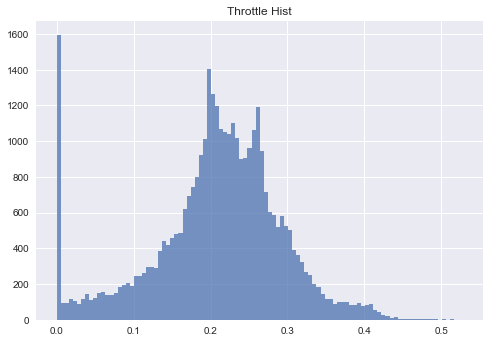

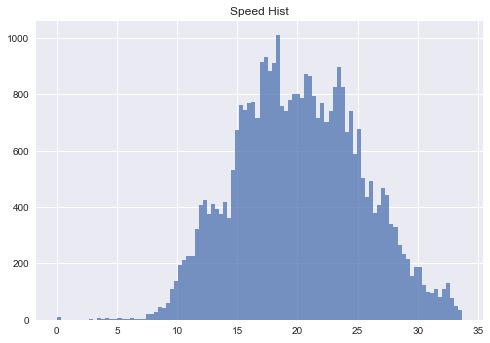

In [335]:
reload(visualization)
from visualization import hist
hist(df_train, 'steering', title='Steering Hist')
hist(df_train, 'brake', title='Brake Hist')
hist(df_train, 'throttle', title='Throttle Hist')
hist(df_train, 'speed', title='Speed Hist')

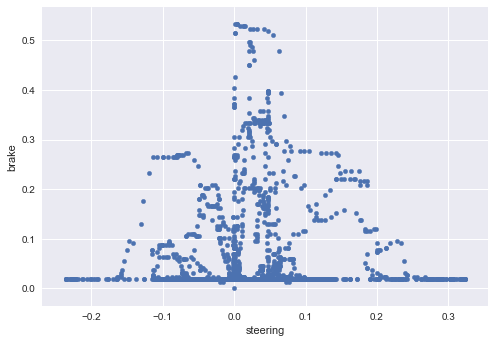

In [165]:
df_train.plot.scatter(x='steering', y='brake')
plt.show()

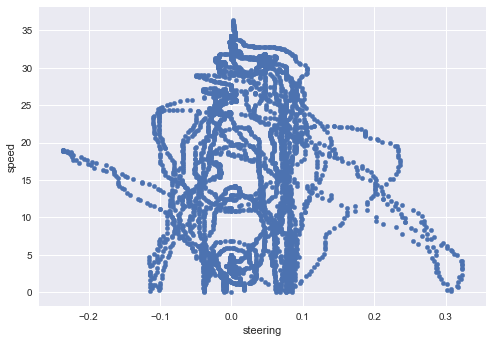

In [166]:
df_train.plot.scatter(x='steering', y='speed')
plt.show()

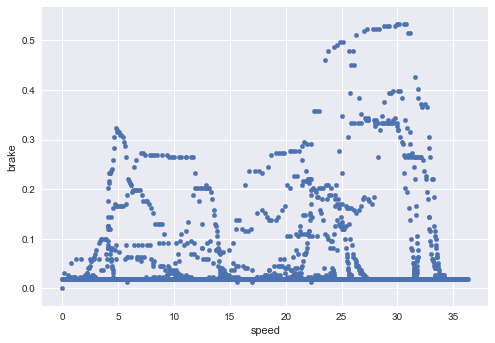

In [167]:
df_train.plot.scatter(x='speed', y='brake')
plt.show()

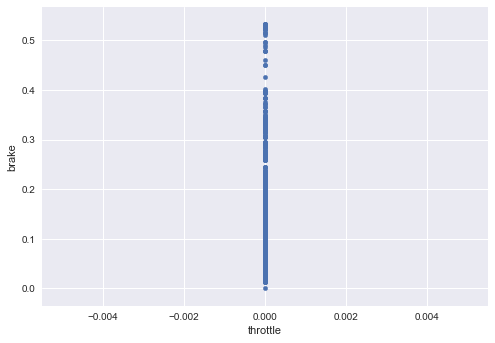

In [168]:
df_train.plot.scatter(x='throttle', y='brake')
plt.show()

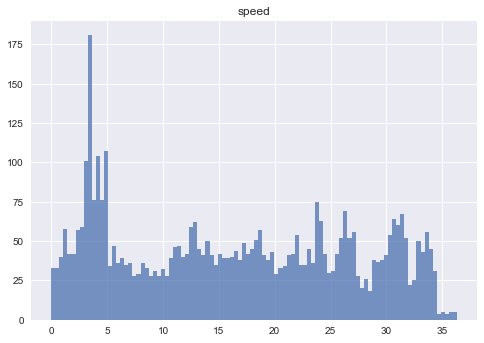

In [169]:
for col in COLUMNS_TO_NORMALIZE:
    hist(df_train, col, col)

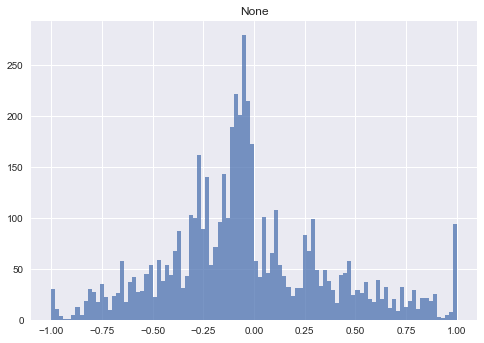

In [20]:
data = df_train
zeros = data.where(data['steering'] == 0).dropna(axis=0)
non_zeros = data.where(data['steering'] != 0.).dropna(axis=0)
# data = zeros.append(non_zeros)
hist(non_zeros, 'steering')

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

raw_text = 'prepare the dataset of input to output pairs encoded as integers'
seq_length = 3
dataX = []
dataY = []
for i in range(0, len(raw_text) - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char for char in seq_in])
    dataY.append(seq_out)
    n_patterns = len(dataX)
    
print(np.array(dataX).shape)
data_dim = 16
timesteps = 8
num_classes = 10
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, 2)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, num_classes))

# Generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100, num_classes))

print(model.summary())
print(dataX)
print()
print(dataY)

# model.fit(x_train, y_train, batch_size=64,validation_data=(x_val, y_val))

(61, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 8, 32)         4480        lstm_input_1[0][0]               
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 8, 32)         8320        lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 32)            8320        lstm_2[0][0]                     
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            330         lstm_3[0][0]                     
Total params: 21,450
Trainable params: 21,450
Non-trainable params: 0
_____________

# LSTM

In [13]:
# reload(loader)
from loader import *
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model
from keras.models import model_from_json
import numpy as np

ROOT = '/Users/nando/workspace/thunderhill_data'
OUTPUT = '/Users/nando/workspace/Downloads/test'
SCALER = 'scaler.p'
df = getDataFromFolder(ROOT, OUTPUT, randomize=False, split=True)

model_file = '/Users/nando/Downloads/model.json'
model_weights = '/Users/nando/Downloads/model.h5'
with open(model_file, 'r') as f:
    model = model_from_json(f.read())
print(model.summary())
N = 11
model.compile("adam", "mse")
model.load_weights(model_weights)
feature_extractor = Model(input=model.layers[0].input, output=model.layers[N].output)
feature_extractor.compile(optimizer='adam', loss='mse')

--  /Users/nando/workspace/thunderhill_data/dataset_sim_000_km_few_laps/driving_log.csv
--  /Users/nando/workspace/thunderhill_data/dataset_sim_001_km_320x160/driving_log.csv
--  /Users/nando/workspace/thunderhill_data/dataset_sim_002_km_320x160_recovery/driving_log.csv
--  /Users/nando/workspace/thunderhill_data/dataset_sim_003_km_320x160/driving_log.csv
--  /Users/nando/workspace/thunderhill_data/dataset_sim_004_km_320x160_cones_brakes/driving_log.csv
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 160, 3)    0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 38, 78, 24)    1824        input_1[0][0]                    
_____________________________________

In [189]:
import os

ROOT = '/Users/nando/workspace/thunderhill_data'
OUTPUT = '/Users/nando/workspace/selfdrivingcar/thunderhill/lstm'

def getDataFromFolder(folder, output, normalize=False, randomize=True, balance=True, split=True):
    data = pd.DataFrame(columns=COLUMNS)
    for csvpath in glob.glob('{}/**/driving_log.csv'.format(folder)):
        print('-- ', csvpath)
        df = pd.read_csv(csvpath)
        df.columns = COLUMNS

        skip = False
        for toSkip in SKIP:
            if toSkip in csvpath:
                skip = True
        if skip:
            continue
        basename = os.path.dirname(csvpath)
        df['center'] = basename + '/' + df['center']
        df['positionX'], df['positionY'], df['positionZ'] = df['position'].str.split(':', 2).str
        df['rotationX'], df['rotationY'], df['rotationZ'] = df['rotation'].str.split(':', 2).str
        df[COLUMNS_TO_NORMALIZE] = df[COLUMNS_TO_NORMALIZE].astype(float)
        data = data.append(df, ignore_index=True)

    data = data.drop(['right', 'left'], 1)

    if balance:
        # data = data.where(data['steering'] != 0).dropna(axis=0)
        zeros = data.where(data['steering'] == 0).dropna(axis=0).sample(1000)
        non_zeros = data.where(data['steering'] != 0).dropna(axis=0)
        data = zeros.append(non_zeros, ignore_index=True)

    if randomize:
        data = shuffle(data)

    if normalize:
        scaler = StandardScaler()
        data[COLUMNS_TO_NORMALIZE] = scaler.fit_transform(data[COLUMNS_TO_NORMALIZE])
        pickle.dump(scaler, open(os.path.join(output, SCALER), 'wb'))

    if split:
        return train_test_split(data, test_size=0.2, random_state=42)
    return data

df = getDataFromFolder(ROOT, None, randomize=False, balance=False, split=False)

print(len(df))

def load_from_h5(model_file, out):
    _model = load_model(model_file)
    model = Model(input=_model.layers[0].input, output=_model.layers[out].output)

    for layer in model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='mse')
    return model

def getFeaturesPath(impath):
    basename = os.path.basename(os.path.splitext(impath)[0]) + '.p'
    root = os.path.join('FEATURES', OUTPUT, impath.split('/')[5])
    if not os.path.exists(root):
        os.makedirs(root)
    fpath = os.path.join(root, basename)
    return fpath

def extractCNNFeatures(df, model_file, layer_out=11):
    features_extractor = load_from_h5(model_file, layer_out)
    for idx, row in df.iterrows():
        impath = row['center']
        fpath = getFeaturesPath(impath)
        img = ReadImg(impath)
        img = Preproc(img)
        cnn_features = features_extractor.predict(np.reshape(img, (1, HEIGHT, WIDTH, DEPTH)))[0]
        pickle.dump(cnn_features, open(fpath, 'wb'))

# extractCNNFeatures(df, model_weights)

# for idx, row in df.head().iterrows():
#     impath = row['center']
#     cnn_features = pickle.load(open(getFeaturesPath(impath), 'rb'))
#     print(cnn_features.shape)

--  /Users/nando/workspace/thunderhill_data/dataset_sim_000_km_few_laps/driving_log.csv
--  /Users/nando/workspace/thunderhill_data/dataset_sim_001_km_320x160/driving_log.csv
--  /Users/nando/workspace/thunderhill_data/dataset_sim_002_km_320x160_recovery/driving_log.csv
--  /Users/nando/workspace/thunderhill_data/dataset_sim_003_km_320x160/driving_log.csv
--  /Users/nando/workspace/thunderhill_data/dataset_sim_004_km_320x160_cones_brakes/driving_log.csv
39697


In [17]:
def Lstm(batch, seq, cnn_size, dropout):
    lstm = Sequential([
        LSTM(
            256,
            batch_input_shape=(None, seq, cnn_size),
            dropout_W=dropout,
            dropout_U=dropout
        ),
        Dense(100, activation='relu'),
        Dropout(dropout),
        Dense(50, activation='relu'),
        Dropout(dropout),
        Dense(10, activation='relu'),
        Dense(1)
    ])
    lstm.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['mse']
    )
    return lstm

def loadFeatures(df, seq_length, batch_size):
    batch_x = []
    batch_y = []
    while True:
        for i in range(0, len(df) - seq_length, 1):
            y = df.iloc[i+seq_length]['steering']
            X = []
            for idx, row in df.iloc[i: i + seq_length].iterrows():
                impath = row['center']
                img = ReadImg(impath)
                img = Preproc(img)
                cnn_features = pickle.load(open(getFeaturesPath(impath), 'rb'))
                X.append(cnn_features)
            batch_x.append(np.reshape(X, (1, seq_length, CNN_INPUT_SIZE)))
            batch_y.append(y)

            if len(batch_x) == batch_size:
                yield np.vstack(batch_x), np.vstack(batch_y)
                batch_x = []
                batch_y = []
                
def loadAllFeatures(df, seq_length, batch_size):
    batch_x = []
    batch_y = []
    for i in range(0, len(df) - seq_length, 1):
        y = df.iloc[i+seq_length]['steering']
        X = []
        for idx, row in df.iloc[i: i + seq_length].iterrows():
            impath = row['center']
            img = ReadImg(impath)
            img = Preproc(img)
            cnn_features = pickle.load(open(getFeaturesPath(impath), 'rb'))
            X.append(cnn_features)
        batch_x.append(np.reshape(X, (1, seq_length, CNN_INPUT_SIZE)))
        batch_y.append(y)

        if len(batch_x) == batch_size:
            yield np.vstack(batch_x), np.vstack(batch_y)
            batch_x = []
            batch_y = []

CNN_INPUT_SIZE = 2496
SEQ_LENGTH = 10
BATCH_SIZE = 512
DATASET = '/Users/nando/Downloads/results'

train_size = int(len(df)*0.7)
df_train = df.iloc[:train_size]
df_val = df.iloc[:train_size]

checkpointer = ModelCheckpoint(os.path.join(DATASET, 'weights.{epoch:02d}-{val_loss:.3f}.hdf5'))

lstm=Lstm(BATCH_SIZE, SEQ_LENGTH, CNN_INPUT_SIZE, BATCH_SIZE)

# lstm.fit_generator(
#     loadFeatures(df_train, SEQ_LENGTH, BATCH_SIZE),
#     nb_epoch=100,
#     samples_per_epoch=BATCH_SIZE*50,
#     validation_data=loadFeatures(df_val, SEQ_LENGTH, BATCH_SIZE),
#     nb_val_samples=BATCH_SIZE*10,
#     callbacks=[
#         checkpointer,
#     ]    
# )

In [25]:
ITERATION = 1
for i in range(ITERATION):
    for x_train, y_train in loadAllFeatures(df, SEQ_LENGTH, BATCH_SIZE):
        lstm.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=1)

Epoch 1/1
512/512 [==============================] - 1s - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.0467 - mean_squared_error: 0.0467
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.0775 - mean_squared_error: 0.0775
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.1001 - mean_squared_error: 0.1001
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.0522 - mean_squared_error: 0.0522
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.0466 - mean_squared_error: 0.0466
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.0692 - mean_squared_error: 0.0692
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.0534 - mean_squared_error: 0.0534
Epoch 1/1
512/512 [==============================] - 2s - loss: 0.0584 - mean_squared_error: 0.0584


In [27]:
import os
with open(os.path.join(DATASET, 'model.json'), 'w') as f:
    f.write(lstm.to_json())
    
lstm.save(os.path.join(DATASET, 'model.h5'))

In [104]:
feature_extractor = load_from_h5('/Users/nando/Downloads/model.h5', LAYER)

In [120]:
print(lstm.summary())
prev_image_array = [np.random.rand(CNN_INPUT_SIZE)]*SEQ_LENGTH
steering_angle = float(
    lstm.predict(np.array(prev_image_array)[None, :], batch_size=BATCH_SIZE)
)
print(steering_angle)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_30 (LSTM)                   (None, 256)           2819072     lstm_input_25[0][0]              
____________________________________________________________________________________________________
dense_30 (Dense)                 (None, 100)           25700       lstm_30[0][0]                    
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 100)           0           dense_30[0][0]                   
____________________________________________________________________________________________________
dense_31 (Dense)                 (None, 50)            5050        dropout_3[0][0]                  
___________________________________________________________________________________________

In [55]:
batch_X = np.vstack(X)
batch_y = np.vstack(y)
print(batch_X.shape)
print(batch_y.shape)
def train(iterations):
    for i in range(iterations):
        model.reset_states()
        model.fit(batch_X[:64], batch_y[:64], batch_size=64, shuffle=False, verbose=1)

(39697, 3, 2496)
(39697, 1)


In [ ]:
BATCH_SIZE = 
# model = Lstm(BATCH_SIZE, SEQ_LENGTH, CNN_INPUT_SIZE, 0.2)
# print(model.summary())
# for i in range(1):
#     model.reset_states()
#     model.fit(batch_X[:BATCH_SIZE], batch_y[:BATCH_SIZE], batch_size=BATCH_SIZE, shuffle=False, verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_33 (LSTM)                   (39697, 256)          2819072     lstm_input_23[0][0]              
____________________________________________________________________________________________________
dense_18 (Dense)                 (39697, 1)            257         lstm_33[0][0]                    
Total params: 2,819,329
Trainable params: 2,819,329
Non-trainable params: 0
____________________________________________________________________________________________________
None
Epoch 1/10


# Brake

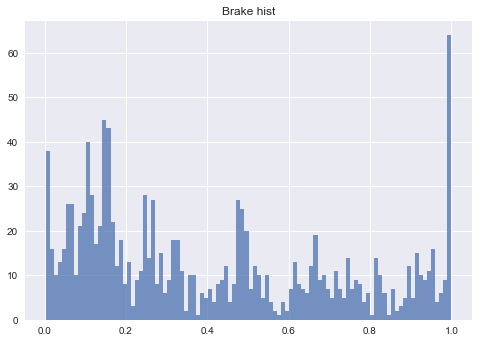

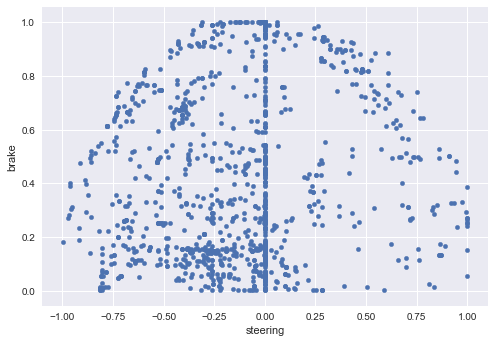

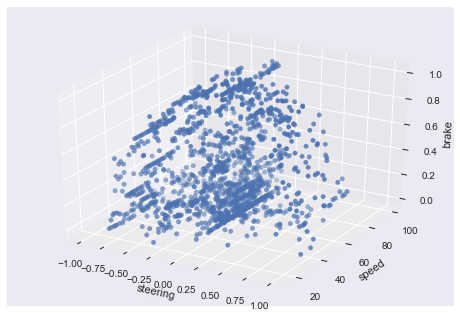

In [83]:
zeros = df.where(df['brake'] == 0).dropna(axis=0).sample(300)
non_zeros = df.where(df['brake'] != 0).dropna(axis=0)
df_brake = zeros.append(non_zeros)
hist(non_zeros, 'brake', 'Brake hist')
non_zeros.plot.scatter(x='steering', y='brake')
plt.show()
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(df_brake['steering'], df_brake['speed'], df_brake['brake'])
threedee.set_xlabel('steering')
threedee.set_ylabel('speed')
threedee.set_zlabel('brake')
plt.show()

In [155]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

def brakeToFeat(df):
    y = df['brake'] != 0
    return y.astype(int)

df = shuffle(df)
df_train, df_test = train_test_split(df_brake, test_size=0.2, random_state=42)

print('TRAIN ', len(df_train))
print('TEST  ', len(df_test))

TRAIN  1234
TEST   309


In [156]:
clf = RandomForestClassifier(
    n_estimators=25,
    criterion='entropy', 
    oob_score=False,
#     class_weight={0: 0.95, 1: 0.2}, 
    n_jobs=-1
)

clf.fit(df_train[['steering', 'speed']], brakeToFeat(df_train))

y_pred = clf.predict(df_test[['steering', 'speed']])
y_true = brakeToFeat(df_test)

print('Accuracy  : ', 100*accuracy_score(y_true, y_pred))
print('Precision : ', 100*precision_score(y_true, y_pred))
print('Recall    : ', 100*recall_score(y_true, y_pred))
print('F1 score  : ', 100*f1_score(y_true, y_pred))
print('True ', np.histogram(y_true)[0])
print('Pred ', np.histogram(y_pred)[0])
pickle.dump(clf, open('../nvidia/BRAKE.p', 'wb'))
confusion_matrix(y_true, y_pred)

Accuracy  :  75.4045307443
Precision :  82.4817518248
Recall    :  88.9763779528
F1 score  :  85.6060606061
True  [ 55   0   0   0   0   0   0   0   0 254]
Pred  [ 35   0   0   0   0   0   0   0   0 274]


array([[  7,  48],
       [ 28, 226]])

In [152]:
steering_angle = -1
speed = '70'
brake = clf.predict(np.array([steering_angle, float(speed)])[None, :])[0]

1

In [182]:
from sklearn.preprocessing import StandardScaler
ROOT = '/Users/nando/workspace/thunderhill_data'
OUTPUT = ''
SCALER = 'scaler.p'
df = getDataFromFolder(ROOT, OUTPUT, randomize=False, split=True, normalize=True)[0]
df.head()

,brake,center,position,positionX,positionY,positionZ,rotation,rotationX,rotationY,rotationZ,speed,steering,throttle
2353,0.0,/Users/nando/workspace/thunderhill_data/datase...,1222.273:1000.221:20.9562,1222.273,1000.221,20.9562,355.8446:169.2242:1.803933,355.8446,169.2242,1.803933,0.143196,0.048212,0.888368
2074,0.0,/Users/nando/workspace/thunderhill_data/datase...,1449.366:1219.11:9.064118,1449.366,1219.11,9.064118,359.4021:342.7357:357.3039,359.4021,342.7357,357.3039,-0.307132,-0.614829,0.442460
6031,0.0,/Users/nando/workspace/thunderhill_data/datase...,1324.544:1023.147:17.30535,1324.544,1023.147,17.30535,354.6717:268.0226:357.7919,354.6717,268.0226,357.7919,-0.238388,0.462227,0.662108
3759,0.0,/Users/nando/workspace/thunderhill_data/datase...,1574.174:760.7031:22.5788,1574.174,760.7031,22.5788,0.1164619:21.80357:1.206627,0.1164619,21.80357,1.206627,1.216921,-0.101222,0.860024
9997,0.0,/Users/nando/workspace/thunderhill_data/datase...,1254.191:493.4486:40.78104,1254.191,493.4486,40.78104,0.6934946:77.6604:7.209276,0.6934946,77.6604,7.209276,1.220466,-0.057402,0.822637


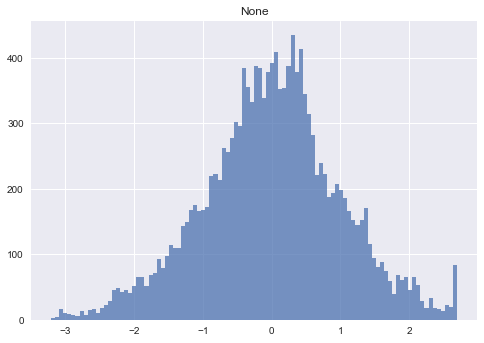

In [233]:
scaler = pickle.load(open(SCALER, 'rb'))
scaler.transform(np.array([speed])[None, :])[0][0]

hist(df, 'speed')

In [237]:
from keras.models import load_model
model = load_model('/Users/nando/Downloads/model.h5')

In [244]:
img = ReadImg(df.iloc[0]['center'])
img = Preproc(img)
image_array = img[20:140, :, :]
image_array = Preproc(image_array)
transformed_image_array = image_array[None, :, :, :]
model.predict(transformed_image_array, batch_size=1)

array([[ 0.05517482,  0.41659462,  0.05155243]], dtype=float32)

In [191]:
import pandas as pd
csvpath = '/Users/nando/workspace/selfdrivingcar/CarND-Behavioral-Training/data'
df = pd.read_csv(csvpath)

In [4]:
df.head()

,path,heading,longitude,latitude,quarternion0,quarternion1,quarternion2,quarternion3,vel0,vel1,vel2,steering,throttle,brake
0,IMG/15395510-1489254863139378.jpeg,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.0,-0.0
1,IMG/15395510-1489254863339216.jpeg,0.0,-2.135204,0.690044,0.006717,-0.003382,0.211303,0.977392,0.009655,0.011152,0.017195,6.529277,-0.0,0.0
2,IMG/15395510-1489254863539252.jpeg,0.0,-2.135204,0.690044,0.006712,-0.003370,0.211323,0.977387,0.013076,0.009249,0.023413,6.529277,-0.0,0.0
3,IMG/15395510-1489254863739272.jpeg,0.0,-2.135204,0.690044,0.006594,-0.003427,0.211284,0.977397,0.013092,0.011309,0.020639,6.529277,-0.0,0.0
4,IMG/15395510-1489254863939228.jpeg,0.0,-2.135204,0.690044,0.006633,-0.003382,0.211310,0.977391,0.012979,0.006630,0.012001,6.536258,-0.0,0.0


# SAMPLING

In [192]:
np.histogram(df['steering'].values)

(array([  225,   626,   995,  2892,  6249, 25547,  1739,   705,   404,   315]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

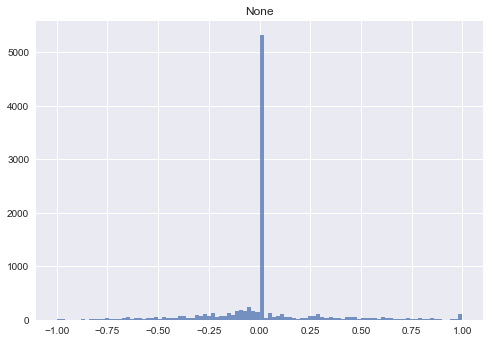

count    39697.000000
mean         1.126100
std          7.521944
min          0.100000
25%          0.100000
50%          0.100000
75%          1.000000
max        100.000000
Name: weight, dtype: float64

In [197]:
df['weight'] = 0
N = 1
df.iloc[df[df['steering'] <= -0.8].index, 13] = 100/(N)
df.iloc[df[(df['steering'] > -.8)&(df['steering'] <= -0.6)].index, 13] = 3/(N)
df.iloc[df[(df['steering'] > -.6)&(df['steering'] <= -0.4)].index, 13] = 2/(N)
df.iloc[df[(df['steering'] > -.4)&(df['steering'] <= -0.2)].index, 13] = 1/(N)
df.iloc[df[(df['steering'] > -.2)&(df['steering'] < 0)].index, 13] = 1/(N*3)
df.iloc[df[df['steering'] == 0].index, 13] = 1/(N*10)
df.iloc[df[(df['steering'] > 0)&(df['steering'] <= 0.2)].index, 13] = 1/(N)
df.iloc[df[(df['steering'] > 0.2)&(df['steering'] <= 0.4)].index, 13] = 1/(N)
df.iloc[df[(df['steering'] > 0.4)&(df['steering'] <= 0.6)].index, 13] = 3/(N)
df.iloc[df[(df['steering'] > 0.6)&(df['steering'] <= 0.8)].index, 13] = 5/(N)
df.iloc[df[df['steering'] > 0.8].index, 13] = 6/(N)
# samples = df.sample(10000, weights='weight', axis=0)
hist(samples, 'steering')
df['weight'].describe()

# TEST

In [195]:
from keras.models import load_model
getDataFromThunderhill(folder, randomize=True, balance=False, split=True)

df_train, df_val = getDataFromThunderhill(ROOT, OUTPUT, balance=False, split=False)

MODEL = ''
BATCH_SIZE = 12
model = load_model(MODEL)
predictions = model.predict(transformed_image_array, batch_size=BATCH_SIZE)

'/Users/nando/workspace/thunderhill_data/dataset_sim_001_km_320x160/IMG/center_2017_03_07_07_31_30_890.jpg'